In [1]:
import itertools, os, sys, time, warnings
import geopandas as gpd
import matplotlib.pyplot as plt
import multiprocessing as mp
import networkx as nx
import numpy as np
import osmnx as ox
import pandas as pd
from shapely.geometry import Point, LineString, Polygon
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [2]:
sys.path.insert(1, "../")
from app_vars import *

In [3]:
assert os.path.exists(DATA_FOLDER)
assert os.path.exists(RESULTS_FOLDER)

In [4]:
_graphml_file = os.path.join(DATA_FOLDER,GRAPHML_FILE)
_grid_file = os.path.join(DATA_FOLDER,GRID_FILE)
_hospital_shapefile = os.path.join(DATA_FOLDER,HOSPITAL_DATA)
_population = os.path.join(DATA_FOLDER,POPULATION_DATA)

In [5]:
assert os.path.exists(_graphml_file)
assert os.path.exists(_grid_file)
assert os.path.exists(_hospital_shapefile)
assert os.path.exists(_population)

In [6]:
G = ox.load_graphml(_graphml_file, node_type=str)
grid_file = gpd.read_file(_grid_file)
hospitals = gpd.read_file(_hospital_shapefile)
pop_data = gpd.read_file(_population)

In [7]:
def network_setting(network):
    _nodes_removed = len([n for (n, deg) in network.out_degree() if deg ==0])
    network.remove_nodes_from([n for (n, deg) in network.out_degree() if deg ==0])
    for component in list(nx.strongly_connected_components(network)):
        if len(component)<10:
            for node in component:
                _nodes_removed+=1
                network.remove_node(node)
    for u, v, k, data in tqdm(G.edges(data=True, keys=True),position=0):
        if 'maxspeed' in data.keys():
            speed_type = type(data['maxspeed'])
            if (speed_type==str):
                if len(data['maxspeed'].split(','))==2:
                    data['maxspeed']=float(data['maxspeed'].split(',')[0])                  
                elif data['maxspeed']=='signals':
                    data['maxspeed']=35.0 # drive speed setting as 35 miles
                else:
                    data['maxspeed']=float(data['maxspeed'].split()[0])
            else:
                data['maxspeed']=float(data['maxspeed'][0].split()[0])
        else:
            data['maxspeed']= 35.0 #miles
        data['maxspeed_meters'] = data['maxspeed']*26.8223 # convert mile to meter
        data['time'] = float(data['length'])/ data['maxspeed_meters']
    print("Removed {} nodes ({:2.4f}%) from the OSMNX network".format(_nodes_removed, _nodes_removed/float(network.number_of_nodes())))
    print("Number of nodes: {}".format(network.number_of_nodes()))
    print("Number of edges: {}".format(network.number_of_edges()))
    return(network)

In [8]:
def hospital_setting(hospitals, G):
    hospitals['nearest_osm']=None
    for i in tqdm(hospitals.index, desc="Find the nearest osm from hospitals", position=0):
        hospitals['nearest_osm'][i] = ox.get_nearest_node(G, [hospitals['Y'][i], hospitals['X'][i]], method='euclidean') # find the nearest node from hospital location
    print ('hospital setting is done')
    return(hospitals)

In [9]:
# to estimate the centroids of census tract / county
def pop_centroid (pop_data, pop_type, pop_geoid):
    pop_data = pop_data.to_crs({'init': 'epsg:4326'})
    pop_data=pop_data[pop_data[pop_type]>=0] 
    pop_cent = pop_data.centroid
    pop_centroid = gpd.GeoDataFrame()
    i = 0
    for point in tqdm(pop_cent, desc='Pop Centroid File Setting', position=0):
        pop = pop_data.iloc[i][pop_type]
        code = pop_data.iloc[i][pop_geoid]
        pop_centroid = pop_centroid.append({'code':code,'pop': pop,'geometry': point}, ignore_index=True)
        i = i+1
    return(pop_centroid)

In [10]:
def calculate_catchment_area(G, nearest_osm, distance, distance_unit = "time"):
    road_network = nx.ego_graph(G, nearest_osm, distance, distance=distance_unit) 
    nodes = [Point((data['x'], data['y'])) for node, data in road_network.nodes(data=True)]
    polygon = gpd.GeoSeries(nodes).unary_union.convex_hull ## to create convex hull
    polygon = gpd.GeoDataFrame(gpd.GeoSeries(polygon)) ## change polygon to geopandas
    polygon = polygon.rename(columns={0:'geometry'}).set_geometry('geometry')
    return polygon.copy(deep=True)

In [11]:
def hospital_measure_acc (_thread_id, hospital, pop_data, distances, weights):
    ##distance weight = 1, 0.68, 0.22
    polygons = []
    for distance in distances:
        polygons.append(calculate_catchment_area(G, hospital['nearest_osm'],distance))
    for i in reversed(range(1, len(distances))):
        polygons[i] = gpd.overlay(polygons[i], polygons[i-1], how="difference")
        
    num_pops = []
    for j in pop_data.index:
        point = pop_data['geometry'][j]
        for k in range(len(polygons)):
            if len(polygons[k]) > 0: # to exclude the weirdo (convex hull is not polygon)
                if (point.within(polygons[k].iloc[0]["geometry"])):
                    num_pops.append(pop_data['pop'][j]*weights[k])  
    total_pop = sum(num_pops)
    for i in range(len(distances)):
        polygons[i]['time']=distances[i]
        polygons[i]['total_pop']=total_pop
        polygons[i]['hospital_icu_beds'] = float(hospital['Adult ICU'])/polygons[i]['total_pop'] # proportion of # of beds over pops in 10 mins
        polygons[i]['hospital_vents'] = float(hospital['Total Vent'])/polygons[i]['total_pop'] # proportion of # of beds over pops in 10 mins
        polygons[i].crs = { 'init' : 'epsg:4326'}
        polygons[i] = polygons[i].to_crs({'init':'epsg:32616'})
    print('\rCatchment for hospital {:4.0f} complete'.format(_thread_id), end="")
    return(_thread_id, [ polygon.copy(deep=True) for polygon in polygons ])

In [12]:
def hospital_acc_unpacker(args):
    return hospital_measure_acc(*args)

def measure_acc_par (hospitals, pop_data, network, distances, weights, num_proc = 4):
    catchments = []
    for distance in distances:
        catchments.append(gpd.GeoDataFrame())
    pool = mp.Pool(processes = num_proc)
    hospital_list = [ hospitals.iloc[i] for i in range(len(hospitals)) ]
    results = pool.map(hospital_acc_unpacker, zip(range(len(hospital_list)), hospital_list, itertools.repeat(pop_data), itertools.repeat(distances), itertools.repeat(weights)))
    pool.close()
    results.sort()
    results = [ r[1] for r in results ]
    for i in range(len(results)):
        for j in range(len(distances)):
            catchments[j] = catchments[j].append(results[i][j], sort=False)
    return catchments

In [13]:
from collections import Counter
def overlap_calc(_id, poly, grid_file, weight, service_type):
    value_dict = Counter()
    if type(poly.iloc[0][service_type])!=type(None):           
        value = float(poly[service_type])*weight
        intersect = gpd.overlay(grid_file, poly, how='intersection')
        intersect['overlapped']= intersect.area
        intersect['percent'] = intersect['overlapped']/intersect['area']
        intersect=intersect[intersect['percent']>=0.5]
        intersect_region = intersect['id']
        for intersect_id in intersect_region:
            try:
                value_dict[intersect_id] +=value
            except:
                value_dict[intersect_id] = value
    return(_id, value_dict)

def overlap_calc_unpacker(args):
    return overlap_calc(*args)

In [14]:
def overlapping_function (grid_file, catchments, service_type, weights, num_proc = 4):
    grid_file[service_type]=0
    pool = mp.Pool(processes = num_proc)
    acc_list = []
    for i in range(len(catchments)):
        acc_list.extend([ catchments[i][j:j+1] for j in range(len(catchments[i])) ])
    acc_weights = []
    for i in range(len(catchments)):
        acc_weights.extend( [weights[i]]*len(catchments[i]) )
    results = pool.map(overlap_calc_unpacker, zip(range(len(acc_list)), acc_list, itertools.repeat(grid_file), acc_weights, itertools.repeat(service_type)))
    pool.close()
    results.sort()
    results = [ r[1] for r in results ]
    service_values = results[0]
    for result in results[1:]:
        service_values+=result
    for intersect_id, value in service_values.items():
        grid_file.loc[grid_file['id']==intersect_id, service_type] += value
    return(grid_file)

In [15]:
def normalization (result, res):
    result[res]=(result[res]-min(result[res]))/(max(result[res])-min(result[res]))
    return result

In [16]:
def output_map(output_grid, base_map, hospitals, resource, RESULTS_FOLDER):
    ax=output_grid.plot(column=resource, cmap='OrRd',figsize=(18,12), legend=True, zorder=1)
    base_map.plot(ax=ax, facecolor="none", edgecolor='gray', lw=0.1)
    ax.scatter(hospitals.X, hospitals.Y, zorder=1, c='black', s=8)
    plt.savefig(os.path.join(RESULTS_FOLDER, "map.png"))

In [17]:
G = network_setting (G)
pop_data = pop_centroid(pop_data, POP_COLUMN, POP_GEOID_COLUMN)
hospitals = hospital_setting(hospitals, G)
distances=[10,20,30] # distances in travel time
weights=[1.0, 0.68, 0.22] # weights where weights[0] is applied to distances[0]

100%|██████████| 75895/75895 [00:00<00:00, 830537.37it/s]


Removed 108 nodes (0.0038%) from the OSMNX network
Number of nodes: 28433
Number of edges: 75895


Find the nearest osm from hospitals: 100%|██████████| 66/66 [00:01<00:00, 33.85it/s]

hospital setting is done


In [18]:
catchments = measure_acc_par(hospitals, pop_data, G, distances, weights, num_proc=PROCESSORS)

Catchment for hospital   65 complete

In [19]:
for j in range(len(catchments)):
    catchments[j] = catchments[j][catchments[j][RESOURCE]!=float('inf')]
result=overlapping_function (grid_file, catchments, RESOURCE, weights, num_proc=PROCESSORS)

In [20]:
result.head()

,left,top,right,bottom,id,area,geometry,hospital_vents
0,440843.416087,4.638515e+06,441420.766356,4.638015e+06,4158,216661.173,"POLYGON ((440843.416 4638265.403, 440987.754 4...",0.000624
1,440843.416087,4.638015e+06,441420.766356,4.637515e+06,4159,216661.168,"POLYGON ((440843.416 4637765.403, 440987.754 4...",0.000626
2,440843.416087,4.639515e+06,441420.766356,4.639015e+06,4156,216661.169,"POLYGON ((440843.416 4639265.403, 440987.754 4...",0.000646
3,440843.416087,4.639015e+06,441420.766356,4.638515e+06,4157,216661.171,"POLYGON ((440843.416 4638765.403, 440987.754 4...",0.000637
4,440843.416087,4.640515e+06,441420.766356,4.640015e+06,4154,216661.171,"POLYGON ((440843.416 4640265.403, 440987.754 4...",0.000635


In [21]:
result.to_file(os.path.join(RESULTS_FOLDER, "result.geojson"), driver='GeoJSON')
result = normalization (result, RESOURCE)

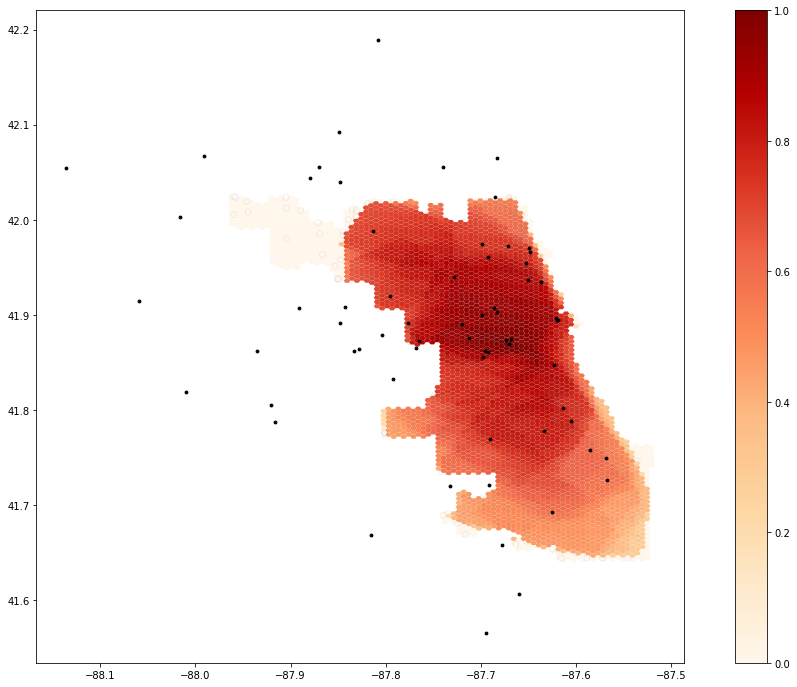

In [22]:
result = result.to_crs({'init': 'epsg:4326'})
output_map(result, pop_data, hospitals, RESOURCE, RESULTS_FOLDER)